# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br 

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/469

Instituto de Computação - Unicamp 2022

In [1]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [3]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

/tmp/ipykernel_79058/1485874194.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
/tmp/ipykernel_79058/1485874194.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()


- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [4]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [5]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [6]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


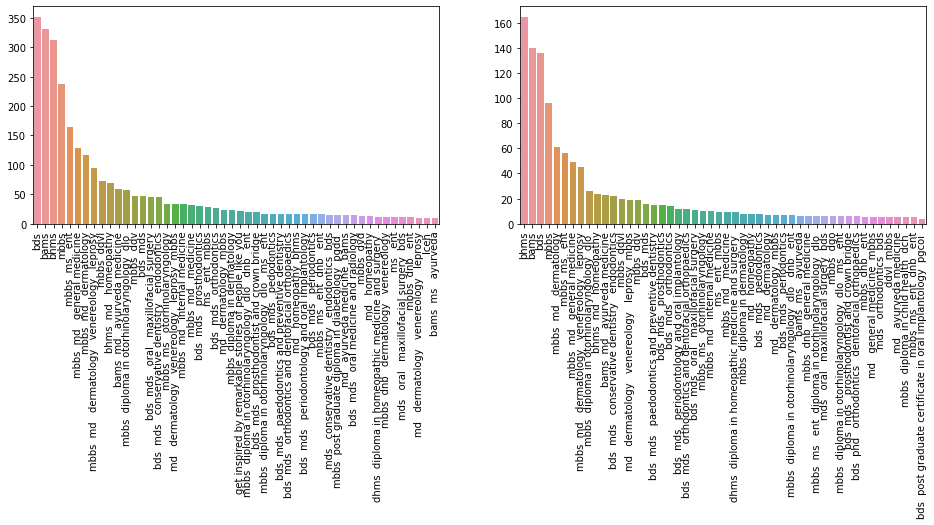

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


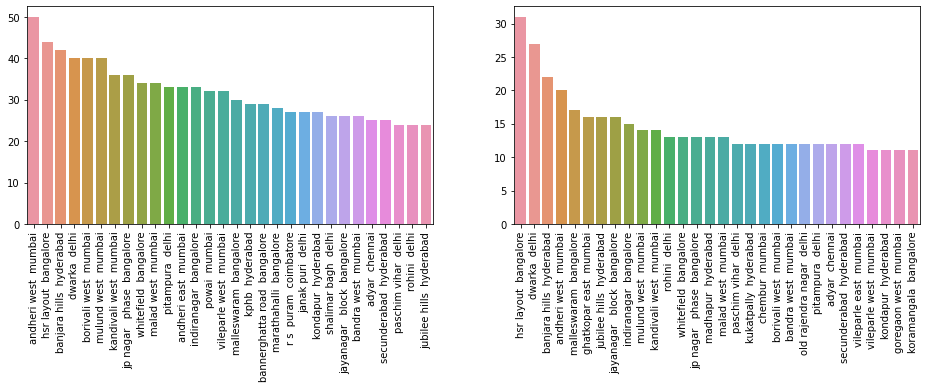

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


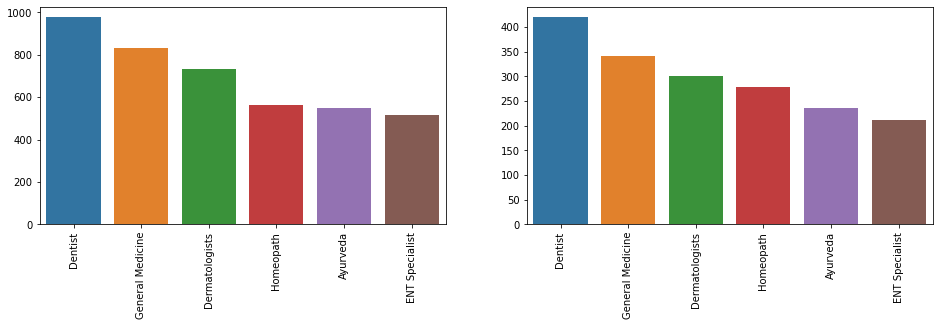

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [11]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [12]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [13]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epsilon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epsilon) afetaram a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [14]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn import metrics

scaler = StandardScaler()
rs = 1082141
np.random.seed(rs)
sns.set()

In [55]:
## Regressor using sigmoid kernel

parameters_kernel = {
    'C': np.logspace(-3, 3, 7), 
    'epsilon': np.logspace(-5, 2, 8)
}

svr_kernel = svm.SVR(kernel='sigmoid')

cv = KFold(n_splits=5, shuffle=True, random_state=rs)

reg_kernel = GridSearchCV(estimator=svr_kernel, 
                          param_grid=parameters_kernel, 
                          cv=cv, 
                          scoring='neg_mean_squared_error')

reg_kernel.fit(train_e, ye_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END .............................C=0.001, epsilon=1e-05; total time=   0.6s
[CV] END .............................C=0.001, epsilon=1e-05; total time=   0.6s
[CV] END .............................C=0.001, epsilon=1e-05; total time=   0.6s
[CV] END .............................C=0.001, epsilon=1e-05; total time=   0.6s
[CV] END .............................C=0.001, epsilon=1e-05; total time=   0.6s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.6s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.6s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.6s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.6s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.6s
[CV] END .............................C=0.001, epsilon=0.001; total time=   0.6s
[CV] END .............................C=0.001, 

[CV] END .................................C=0.1, epsilon=0.1; total time=   0.6s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.6s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.6s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.6s
[CV] END .................................C=0.1, epsilon=1.0; total time=   0.4s
[CV] END .................................C=0.1, epsilon=1.0; total time=   0.4s
[CV] END .................................C=0.1, epsilon=1.0; total time=   0.4s
[CV] END .................................C=0.1, epsilon=1.0; total time=   0.4s
[CV] END .................................C=0.1, epsilon=1.0; total time=   0.4s
[CV] END ................................C=0.1, epsilon=10.0; total time=   0.0s
[CV] END ................................C=0.1, epsilon=10.0; total time=   0.0s
[CV] END ................................C=0.1, epsilon=10.0; total time=   0.0s
[CV] END ...................

[CV] END .............................C=100.0, epsilon=1e-05; total time=   0.7s
[CV] END .............................C=100.0, epsilon=1e-05; total time=   0.7s
[CV] END ............................C=100.0, epsilon=0.0001; total time=   0.7s
[CV] END ............................C=100.0, epsilon=0.0001; total time=   0.7s
[CV] END ............................C=100.0, epsilon=0.0001; total time=   0.7s
[CV] END ............................C=100.0, epsilon=0.0001; total time=   0.7s
[CV] END ............................C=100.0, epsilon=0.0001; total time=   0.7s
[CV] END .............................C=100.0, epsilon=0.001; total time=   0.7s
[CV] END .............................C=100.0, epsilon=0.001; total time=   0.7s
[CV] END .............................C=100.0, epsilon=0.001; total time=   0.7s
[CV] END .............................C=100.0, epsilon=0.001; total time=   0.7s
[CV] END .............................C=100.0, epsilon=0.001; total time=   0.7s
[CV] END ...................

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=SVR(kernel='sigmoid'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'epsilon': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='neg_mean_squared_error', verbose=2)

In [56]:
print(reg_kernel.best_estimator_)

SVR(C=0.01, kernel='sigmoid')


In [85]:
best_reg_kernel = svm.SVR(C=0.01, kernel='sigmoid')

In [86]:
cross_val_score(best_reg_kernel, train_e, ye_train, cv=cv)

array([0.04971081, 0.02810222, 0.03951022, 0.05425883, 0.06479631])

In [58]:
## Regressor using C = 0.01

parameters_C = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'epsilon': np.logspace(-5, 2, 8)
}

svr_C = svm.SVR(C=0.01)

reg_C = GridSearchCV(estimator=svr_C, 
                     param_grid=parameters_C, 
                     cv=cv, 
                     scoring='neg_mean_squared_error',
                     verbose=2,
                     rs=rs)

reg_C.fit(train_e,ye_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .......................epsilon=1e-05, kernel=linear; total time=   0.4s
[CV] END .......................epsilon=1e-05, kernel=linear; total time=   0.4s
[CV] END .......................epsilon=1e-05, kernel=linear; total time=   0.4s
[CV] END .......................epsilon=1e-05, kernel=linear; total time=   0.4s
[CV] END .......................epsilon=1e-05, kernel=linear; total time=   0.4s
[CV] END .........................epsilon=1e-05, kernel=poly; total time=   0.5s
[CV] END .........................epsilon=1e-05, kernel=poly; total time=   0.5s
[CV] END .........................epsilon=1e-05, kernel=poly; total time=   0.5s
[CV] END .........................epsilon=1e-05, kernel=poly; total time=   0.5s
[CV] END .........................epsilon=1e-05, kernel=poly; total time=   0.5s
[CV] END ..........................epsilon=1e-05, kernel=rbf; total time=   1.8s
[CV] END ..........................epsilon=1e-0

[CV] END .........................epsilon=1.0, kernel=linear; total time=   0.2s
[CV] END .........................epsilon=1.0, kernel=linear; total time=   0.2s
[CV] END .........................epsilon=1.0, kernel=linear; total time=   0.2s
[CV] END .........................epsilon=1.0, kernel=linear; total time=   0.2s
[CV] END ...........................epsilon=1.0, kernel=poly; total time=   0.2s
[CV] END ...........................epsilon=1.0, kernel=poly; total time=   0.2s
[CV] END ...........................epsilon=1.0, kernel=poly; total time=   0.2s
[CV] END ...........................epsilon=1.0, kernel=poly; total time=   0.2s
[CV] END ...........................epsilon=1.0, kernel=poly; total time=   0.3s
[CV] END ............................epsilon=1.0, kernel=rbf; total time=   0.2s
[CV] END ............................epsilon=1.0, kernel=rbf; total time=   0.2s
[CV] END ............................epsilon=1.0, kernel=rbf; total time=   0.2s
[CV] END ...................

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=SVR(C=0.01),
             param_grid={'epsilon': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [88]:
print(reg_C.best_estimator_)

SVR(C=0.01, kernel='linear')


In [91]:
best_reg_eps = svm.SVR(C=0.01, kernel='linear')

In [92]:
cross_val_score(best_reg_eps, train_e, ye_train, cv=cv)

array([0.11795188, 0.09916515, 0.09769922, 0.10249807, 0.11848293])

In [62]:
## Regressor using epsilon = 0.5

parameters_eps = {
    'kernel': ['linear', 'rbf', 'sigmoid'], 
    'C': np.logspace(-5, 2, 8)}

svr_eps = svm.SVR(epsilon=0.5)

reg_eps = GridSearchCV(estimator=svr_eps, 
                       param_grid=parameters_eps,
                       cv=cv, 
                       scoring='neg_mean_squared_error')

reg_eps.fit(train_e, ye_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .............................C=1e-05, kernel=linear; total time=   0.3s
[CV] END .............................C=1e-05, kernel=linear; total time=   0.3s
[CV] END .............................C=1e-05, kernel=linear; total time=   0.3s
[CV] END .............................C=1e-05, kernel=linear; total time=   0.3s
[CV] END .............................C=1e-05, kernel=linear; total time=   0.3s
[CV] END ................................C=1e-05, kernel=rbf; total time=   0.3s
[CV] END ................................C=1e-05, kernel=rbf; total time=   0.3s
[CV] END ................................C=1e-05, kernel=rbf; total time=   0.3s
[CV] END ................................C=1e-05, kernel=rbf; total time=   0.3s
[CV] END ................................C=1e-05, kernel=rbf; total time=   0.3s
[CV] END ............................C=1e-05, kernel=sigmoid; total time=   0.4s
[CV] END ............................C=1e-05, k

[CV] END .............................C=10.0, kernel=sigmoid; total time=   0.6s
[CV] END .............................C=10.0, kernel=sigmoid; total time=   0.6s
[CV] END .............................C=10.0, kernel=sigmoid; total time=   0.6s
[CV] END .............................C=10.0, kernel=sigmoid; total time=   0.6s
[CV] END .............................C=100.0, kernel=linear; total time=  18.6s
[CV] END .............................C=100.0, kernel=linear; total time=  13.9s
[CV] END .............................C=100.0, kernel=linear; total time=  15.6s
[CV] END .............................C=100.0, kernel=linear; total time=  15.0s
[CV] END .............................C=100.0, kernel=linear; total time=  14.5s
[CV] END ................................C=100.0, kernel=rbf; total time=   1.1s
[CV] END ................................C=100.0, kernel=rbf; total time=   1.1s
[CV] END ................................C=100.0, kernel=rbf; total time=   1.1s
[CV] END ...................

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=SVR(epsilon=0.5),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [63]:
print(reg_eps.best_estimator_)

SVR(epsilon=0.5)


In [72]:
best_reg_eps = svm.SVR(epsilon=0.5)

In [77]:
cross_val_score(best_clf_eps, train_e, ye_train, cv=cv)

array([0.19302397, 0.18686775, 0.19923012, 0.16260214, 0.1510092 ])

In [101]:
## O melhor parece ser o usando sigmoide
best_model_svr = svm.SVR(epsilon=0.5)

In [102]:
best_model_svr.fit(train_e, ye_train)

SVR(epsilon=0.5)

In [103]:
y_pred = best_model_svr.predict(test_e)

In [104]:
metrics.mean_squared_error(y_pred, ye_test)

0.7924806327830223

**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regeressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=rs)

clf_kernel = GridSearchCV(estimator=lin_model, 
                          param_grid=parameters_kernel, 
                          cv=cv, 
                          scoring='neg_mean_squared_error')

clf_kernel.fit(train_e, ye_train)

In [82]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor()

cv = KFold(n_splits=5, shuffle=True, random_state=rs)

max_depth = [int(x) for x in np.linspace(10, 120, 10)] 
min_samples_split = list(range(2,10))
min_samples_leaf = [1, 2, 3, 4, 5]


param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}



reg_tree = GridSearchCV(estimator=decision_tree, 
                          param_grid=param_grid, 
                          cv=cv, 
                          scoring='neg_mean_squared_error')

reg_tree.fit(train_e, ye_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1082141, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [84]:
print(reg_tree.best_estimator_)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=4)


In [97]:
## O melhor parece ser o usando sigmoide
best_model_dtree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=4)

In [98]:
best_model_dtree.fit(train_e, ye_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=4)

In [99]:
y_pred = best_model_dtree.predict(test_e)

In [100]:
metrics.mean_squared_error(y_pred, ye_test)

0.8643412216508013

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [105]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 256 primeiras amostras no conjunto de treinamento

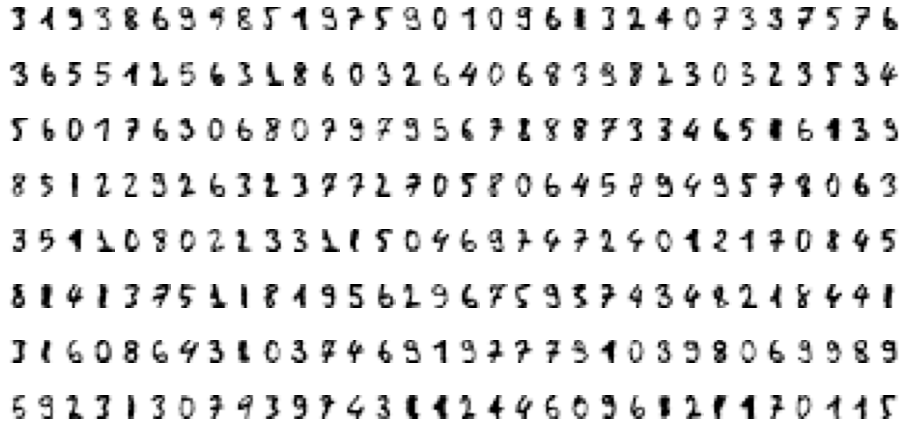

In [106]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

/home/nelson/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other a

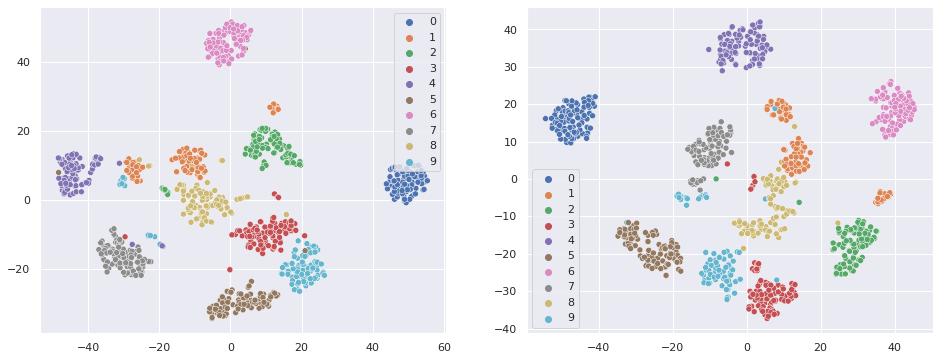

In [107]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nelson/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


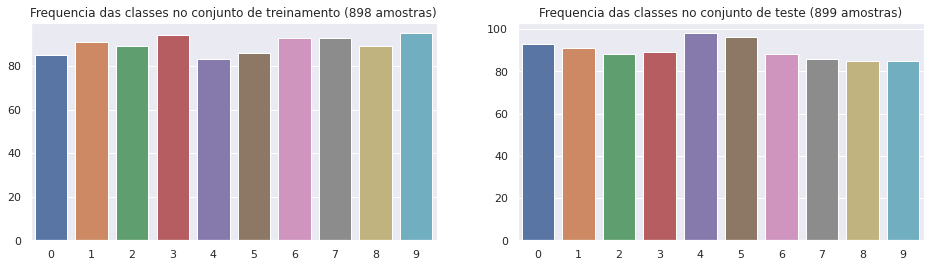

In [108]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

In [109]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

scaler = StandardScaler()

# Scaling the training data
x_train = scaler.fit_transform(x_train)

In [113]:
C_param = {'C': np.logspace(-5, 3, 9)}

svc_C = svm.SVC(kernel='linear')

cv = KFold(n_splits=10, shuffle=True, random_state=rs)

clf_C = GridSearchCV(estimator=svc_C, param_grid=C_param, cv=cv)

clf_C.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
             estimator=SVC(kernel='linear'),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])})

In [114]:
print(clf_C.best_estimator_)

SVC(C=0.1, kernel='linear')


### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

In [117]:
best_svc = svm.SVC(C=0.1, kernel='linear')

In [119]:
best_svc.fit(x_train, y_train)

y_pred_test = best_svc.predict(x_test)

The accuracy of the best SVM model for the test set is 0.8398220244716351 and the precision for the digits from 0 to 9 is 0.8398220244716351


Text(0.5, 1.0, 'Confusion Matrix')

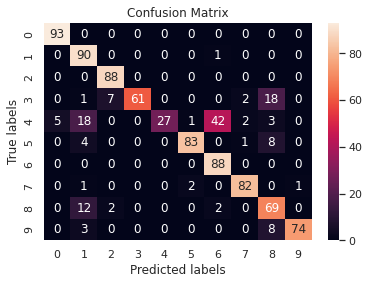

In [120]:
# Applying accuracy and precision
acc_best_svm_test = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
prec_best_svm_test = metrics.precision_score(y_true=y_test, y_pred=y_pred_test, average='micro')
print(f"The accuracy of the best SVM model for the test set is {acc_best_svm_test} and the precision for the digits from 0 to 9 is {prec_best_svm_test}")

# Confusion matrix
cm_best_svm_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test)
ax= plt.subplot()
sns.heatmap(cm_best_svm_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [147]:
param_C_gamma = {
    'C': np.logspace(-2, 3, 6), 
    'gamma': np.logspace(-9, 3, 13)
}

In [148]:
svc_C_gamma = svm.SVC(kernel='rbf')

clf_C_gamma = GridSearchCV(estimator=svc_C_gamma, param_grid=param_C_gamma, cv=cv)

clf_C_gamma.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
             estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [149]:
print(clf_C_gamma.best_estimator_)

SVC(C=1000.0, gamma=0.0001)


**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

In [150]:
param_C_gamma_random = {
    'C': np.logspace(-2, 3, 6), 
    'gamma': np.logspace(-9, 3, 13)
}

svc_random = svm.SVC(kernel='rbf')

clf_random = RandomizedSearchCV(estimator=svc_random,
                                param_distributions=param_C_gamma_random, 
                                cv=cv,
                                random_state=rs)

clf_random.fit(x_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1082141, shuffle=True),
                   estimator=SVC(),
                   param_distributions={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [151]:
print(clf_random.best_estimator_)

SVC(C=1000.0, gamma=0.1)


### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

In [152]:
fst_model = svm.SVC(C=100.0, gamma=0.001)
scd_model = svm.SVC(C=1000.0, gamma=0.1)

In [153]:
fst_model.fit(x_train, y_train)

y_pred_test = fst_model.predict(x_test)

The accuracy of the best SVM model for the test set is 0.1468298109010011 and the precision for the digits from 0 to 9 is 0.1468298109010011


Text(0.5, 1.0, 'Confusion Matrix')

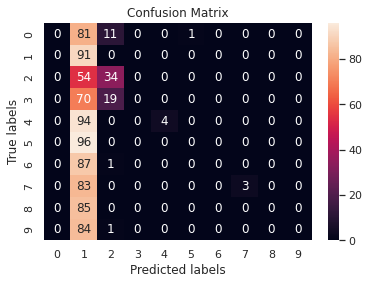

In [154]:
# Applying accuracy and precision
acc_best_svm_test = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
prec_best_svm_test = metrics.precision_score(y_true=y_test, y_pred=y_pred_test, average='micro')
print(f"The accuracy of the best SVM model for the test set is {acc_best_svm_test} and the precision for the digits from 0 to 9 is {prec_best_svm_test}")

# Confusion matrix
cm_best_svm_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test)
ax= plt.subplot()
sns.heatmap(cm_best_svm_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')

In [155]:
scd_model.fit(x_train, y_train)

y_pred_test = scd_model.predict(x_test)

The accuracy of the best SVM model for the test set is 0.1067853170189099 and the precision for the digits from 0 to 9 is 0.1067853170189099


Text(0.5, 1.0, 'Confusion Matrix')

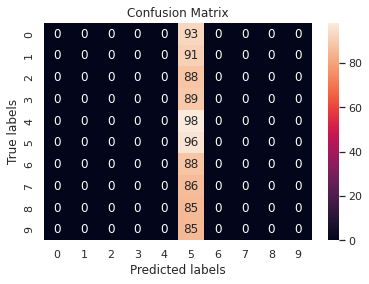

In [156]:
# Applying accuracy and precision
acc_best_svm_test = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
prec_best_svm_test = metrics.precision_score(y_true=y_test, y_pred=y_pred_test, average='micro')
print(f"The accuracy of the best SVM model for the test set is {acc_best_svm_test} and the precision for the digits from 0 to 9 is {prec_best_svm_test}")

# Confusion matrix
cm_best_svm_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test)
ax= plt.subplot()
sns.heatmap(cm_best_svm_test, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')